In [2]:
import numpy as np
import imageio
import sys
import glob
import os
from tqdm import tqdm
import matplotlib.pyplot as plt
imageio.plugins.freeimage.download()
import scipy.stats as st
from mpl_toolkits.axes_grid1 import make_axes_locatable

In [3]:

def load_normal_reals(file):
    normal_files = glob.glob(file)[:100]

    normals = []
    print(len(normal_files))
    for normal_file in normal_files:
        imarr = imageio.imread(normal_file)[1:-1,1:-1,:]
        imarr[~np.isfinite(imarr)] = 0
        normals.append((imarr.reshape(-1, 3) - 0.5) * 2)

    normals = np.array(normals)
    return normals

In [141]:
def plot_normal_collection(normals, label, file, bounds=((None, None), (None, None)), gt_normals=None, vmin=-100, vmax=100):
    #fig, ax = plt.subplots(subplot_kw={'projection': 'polar'})
    fig, ax = plt.subplots(1, 1)

    normals = normals[0][0]#[normals[0][0][:,2]>0]

    hist, X, Y = np.histogram2d(
          normals[:,0], 
          normals[:,1], bins=(50, 50), range=bounds, density=True)
    
    if gt_normals != None:
        gt_normals = gt_normals[0][0]#[gt_normals[0][0][:,2]>0]
        gt_hist, _, _ = np.histogram2d(
          gt_normals[:,0], 
          gt_normals[:,1], bins=(50, 50), range=bounds, density=True)
        hist = (hist-gt_hist) #/ (gt_hist+0.01)
    
    pc = ax.pcolormesh(X, Y, hist.T, vmin=vmin, vmax=vmax)
    plt.colorbar(pc, ax=ax)

    ax.set_xlim(*bounds[0])
    ax.set_ylim(*bounds[1])
    ax.set_facecolor("black")
    ax.grid(False)
    ax.set_title(label)
    ax.set_aspect("equal")
    fig.tight_layout()

def plot_normal_collection_1D(normals, label, file, gt_normals=None):
    #fig, ax = plt.subplots(subplot_kw={'projection': 'polar'})
    fig, ax = plt.subplots()

    # define binning
    rbins = np.linspace(-1, 1, 100)

    for n,l in normals:
        z_vals = n[:,2]
        z_vals = np.clip(z_vals,-1, 1)
        hist, bins = np.histogram(z_vals, weights=np.ones_like(z_vals)/(z_vals.shape[0]), bins=rbins, density=False)
        bins = rbins[1:]
        ax.plot(bins, hist, label=l)

    #hist *= (2.5*np.pi)

    #density = gaussian_kde(z_vals)
    #ax.plot(bins,density(bins), alpha=0.4)


    if gt_normals != None:
        gt_normals = gt_normals[0][0]#[gt_normals[0][0][:,2]>0]
        z_vals = gt_normals[:,2]
        z_vals = np.clip(z_vals,-1, 1)
        hist, bins = np.histogram(z_vals, weights=np.ones_like(z_vals)/(z_vals.shape[0]), bins=rbins, density=False)
        bins = rbins[1:]
        ax.plot(bins, hist, "--", label="beckmann-smith")


    ax.set_xlim(0,1)
    ax.set_title(label)
    ax.set_xlabel("$n_z$")
    ax.legend()
    ax.set_ylabel("$p(n_z)$")
    #ax.set_theta_zero_location("N")
    #ax.set_aspect("equal")
    fig.tight_layout()

    #dir = os.path.join("plots",os.path.split(file)[0])
    #os.makedirs(dir, exist_ok=True)
    #fig.savefig(os.path.join(dir, os.path.basename(file)[:-4] + "-1D.pdf"), dpi=300, bbox_inches='tight',pad_inches=0)
    



[[-0.9163170431266996, 0.9016654663208378], [-0.8864898821069065, 0.9066529119079509]]
testing/ray-realizations/weight-space\se\aniso=[1.0000,1.0000,1.0000]-s=1.000-l=2.000\300-0.00-normals-beckmann.bin


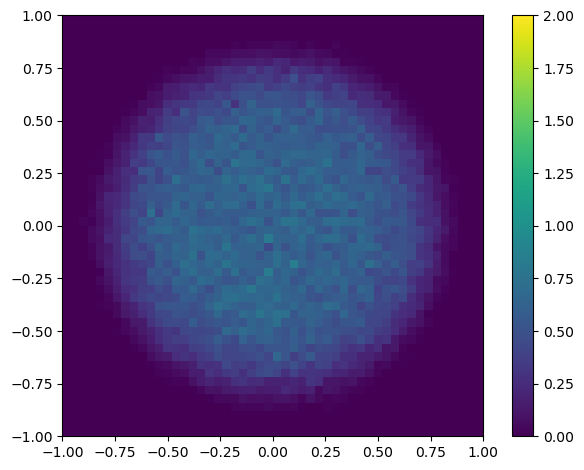

testing/ray-realizations/weight-space\se\aniso=[1.0000,1.0000,1.0000]-s=1.000-l=2.000\300-0.00-normals.bin


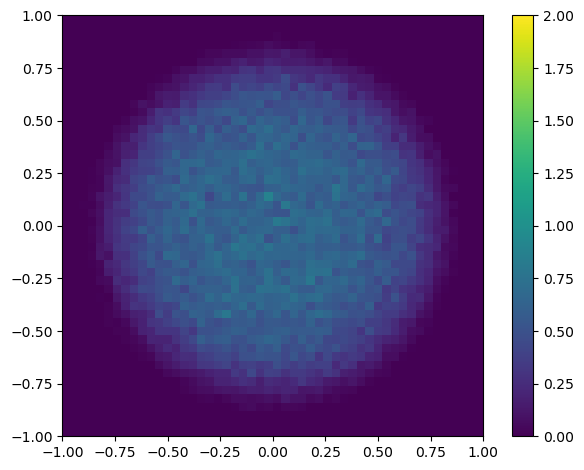

In [162]:

with plt.style.context("seaborn-v0_8-dark"):
    params = {'text.usetex' : True,
            'font.size' : 7,
            'font.family' : 'Linux Libertine'}
    plt.rcParams.update(params)

def br(L2):
    return np.sqrt(2*L2)

normal_files = dict()
bounds = [[np.inf,-np.inf], [np.inf, -np.inf]]

#for file in glob.glob("testing/intersections/*plane*/*reflection*.bin"):
#for file in glob.glob("testing/intersections/gp-medium-plane-softlight-*/*normals*.bin"):
#for file in glob.glob("testing/intersections/*plane*/*normals*.bin"):
#for file in glob.glob("testing/microfacet/normals-validate-nocond/se/*l=0.14*81*.bin"):
#for file in glob.glob("testing/microfacet/normals-validate-nocond/se/*l=0.14*80*.bin"):
#for file in glob.glob("testing/microfacet/normals-validate-nocond/se/*l=0.14*80*.bin"):
#for file in glob.glob("testing/microfacet/normals-validate-nocond/angle-range/se/*.bin"): 
#for file in glob.glob("testing/microfacet/normals-validate-nocond/angle-range/rq/*.bin"):
#for file in glob.glob("testing/microfacet/smith-test/angle-range/*/*256*.bin"):
for file in glob.glob("testing/ray-realizations/weight-space/*/*l=2.0*/300-*0.00*-normals*.bin"):
#for file in glob.glob("normals-validate-nocond/se/*.bin"):

    if("testing/ray-realizations" in file):
        normals = np.reshape(np.fromfile(file, dtype=np.float64), (-1,3))#.T
    else:
        normals = np.reshape(np.fromfile(file, dtype=np.float32), (3,-1)).T

    deg_idx = file.find("deg")
    deg_idx = deg_idx if deg_idx != -1 else -4

    key = file # file[:deg_idx+3] + ".bin"
    if key not in normal_files:
        normal_files[key] = []

    bounds[0][0] = np.minimum(np.min(normals[:,0]), bounds[0][0])
    bounds[0][1] = np.maximum(np.max(normals[:,0]), bounds[0][1])
    bounds[1][0] = np.minimum(np.min(normals[:,1]), bounds[1][0])
    bounds[1][1] = np.maximum(np.max(normals[:,1]), bounds[1][1])
    
    normal_files[key].append((normals, file[deg_idx+3:-4]))
    #plot_normal_collection(normals, file[len("visible-normals/"):], file)

common_prefix = os.path.commonprefix(list(normal_files.keys()))
common_postfix = os.path.commonprefix([k[::-1] for k in list(normal_files.keys())])[::-1]
print(bounds)
    
for k, v in normal_files.items():
    #if "conditioned" not in k:
    #    continue

    #if "beckmann" in k:
    #    continue

    print(k)

    #plot_normal_collection_1D(v, k[len("visible-normals/"):], k, 
    #                        beckmann_roughness=np.round(beckmann_roughness, 4))

    #plot_normal_collection(v, k[len(common_prefix):], k, bounds = ((-0.03, 0.03), (-0.03, 0.03)) if "normals" in k else ((-0.01, 0.01), (-1, -0.98)))

    #plot_normal_collection(v, k[len(common_prefix):], k, bounds = ((-0.03, 0.03), (-0.03, 0.03)) if "normals" in k else ((-0.01, 0.01), (-1, -0.98)),
    #                       gt_normals=normal_files["testing/intersections\\gp-medium-plane-softlight-ref-ndf-no-nee\\surface-reflection.bin"])

    #plot_normal_collection(v, k[len(common_prefix):-len(common_postfix)], k, bounds = ((-0.03, 0.03), (-0.03, 0.03)), vmin=-300, vmax=300,
    #                       gt_normals=normal_files["testing/intersections\\gp-medium-plane-softlight-mean-beckmann\\medium-normals.bin"])
    #plot_normal_collection(v, k[len(common_prefix):], k, bounds = ((-0.3, 0.3), (-0.3, 0.3)))
    #plot_normal_collection(v, k[len(common_prefix):], k, bounds = ((-0.03, 0.03), (-0.03, 0.03)),
    #                       gt_normals=normal_files["testing/microfacet/normals-validate-nocond/se\\aniso=[1.0000,1.0000,0.0000]-s=0.001-l=0.141-67.5deg-32-beckmann-0.200.bin"])
    #plot_normal_collection(v, k[len(common_prefix):], k, bounds = ((-0.03, 0.03), (-0.03, 0.03)), vmin=-100, vmax=100,
    #                       gt_normals=normal_files["testing/microfacet/normals-validate-nocond/se\\aniso=[1.0000,1.0000,0.0000]-s=0.001-l=0.141-81.0deg-32-beckmann-0.020.bin"])

    #plot_normal_collection(v, k[len(common_prefix):], k, bounds = ((-1, 1), (-1, 1)), vmin=-0.25, vmax=0.25, gt_normals=normal_files[k.replace("conditioned_gaussian", "beckmann")])
    #plot_normal_collection_1D(v, k[len(common_prefix):], k, gt_normals=normal_files[k.replace("conditioned_gaussian", "beckmann")])
    
    
    #plot_normal_collection(v, k[len(common_prefix):-len(common_postfix)] + " - error", k, bounds = ((-1, 1), (-1, 1)), vmin=-0.25, vmax=0.25, gt_normals=normal_files[k.replace("-normals", "-normals-beckmann")])
    plot_normal_collection(v, "", k, bounds = ((-1, 1), (-1, 1)), vmin=0, vmax=2)
    
    #lot_normal_collection_1D(v, k[len(common_prefix):], k, gt_normals=normal_files[k.replace("-normals", "-normals-beckmann")])

    #plot_normal_collection(v, k[len(common_prefix):], k, bounds = ((-0.3, 0.3), (-0.3, 0.3)),
    #                       gt_normals=normal_files[k.replace("conditioned_gaussian", "beckmann")], vmin=-1, vmax=1)
    #plot_normal_collection(v, k[len(common_prefix):], k, bounds = bounds)
    plt.show()


